In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
import plotly
import plotly.graph_objs as go
import plotly.express as px

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing

# Model Architecture
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications import VGG19

# System libraries
from pathlib import Path
import os.path

# Visualization Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import seaborn as sns

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Model Hypertunning
!pip install -q keras_tuner
import keras_tuner as kt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Preprocessing

In [3]:
train_path = '/kaggle/input/top-10-best-rated-thai-food/top10_thai_food_dataset/train'
test_path = '/kaggle/input/top-10-best-rated-thai-food/top10_thai_food_dataset/test'
valid_path = '/kaggle/input/top-10-best-rated-thai-food/top10_thai_food_dataset/val'

### Prepare Data Augmentation:

In [4]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    #width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    #height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    #shear_range=0.2,            # Apply shear transformations
    zoom_range=0.2,             # Randomly zoom in by up to 20%
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

# data augmentation for testing
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

# data augmentation for validation
valid_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

In [5]:
images_size = 224
batch_size = 64

TypeError: compute_class_weight() takes 1 positional argument but 3 were given

### Load the Images with a generator:

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(images_size, images_size),  # Resize images to this size
    batch_size=batch_size,           # Number of images in each batch
    seed=32,                         # Optional: Set a random seed for shuffling
    shuffle=True,                    # Shuffle the data during training
    class_mode='categorical'        # Mode for class labels (categorical for one-hot encoding)
)



# Create a generator for testing data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(images_size, images_size),
    batch_size = batch_size,
    class_mode='categorical')


# Create a generator for validation data
valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(images_size, images_size),
    batch_size = batch_size,
    class_mode='categorical')

Found 1977 images belonging to 10 classes.
Found 285 images belonging to 10 classes.
Found 564 images belonging to 10 classes.


In [9]:
type(valid_generator)

keras.preprocessing.image.DirectoryIterator

# Data Distribution

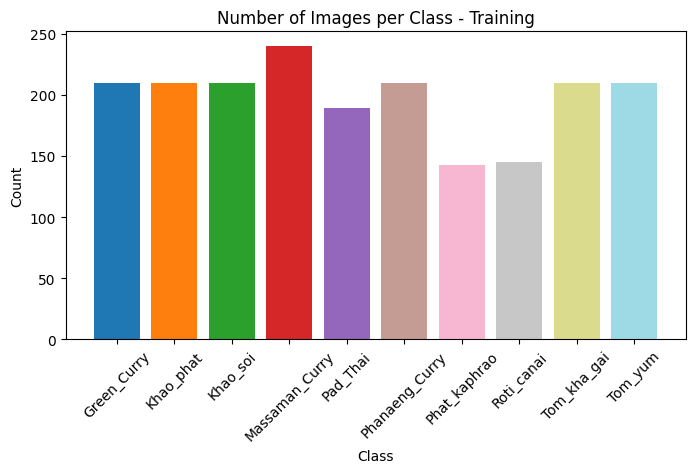

In [7]:
# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(train_generator)):
    batch_data, batch_labels = train_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class - Training')
plt.xticks(rotation=45)

# Add a legend for class colors
#legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
#plt.legend(handles=legend_labels, title="Classes")

plt.show()

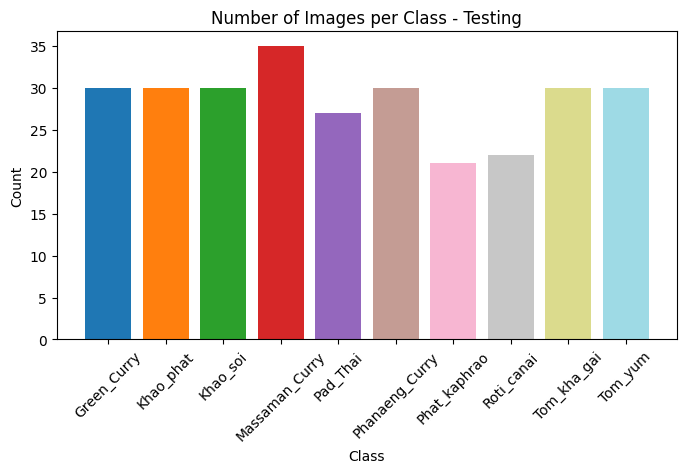

In [8]:
# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(test_generator)):
    batch_data, batch_labels = test_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class - Testing')
plt.xticks(rotation=45)

# Add a legend for class colors
#legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
#plt.legend(handles=legend_labels, title="Classes")

plt.show()

# **Imbalanced Data Handling with Re-Weighting**

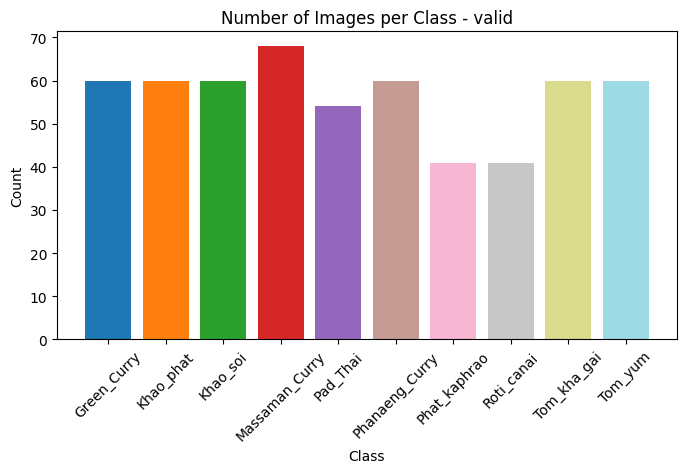

In [9]:
# Get the class labels
class_labels = list(valid_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(valid_generator)):
    batch_data, batch_labels = valid_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class - valid')
plt.xticks(rotation=45)

# Add a legend for class colors
#legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
#plt.legend(handles=legend_labels, title="Classes")

plt.show()

# Visualizing images

In [10]:
def Show_Images(target_gen):
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = list(target_gen.class_indices.keys())

    # Display images with labels
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),20))):
        plt.subplot(5, 5, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()

### Traning data

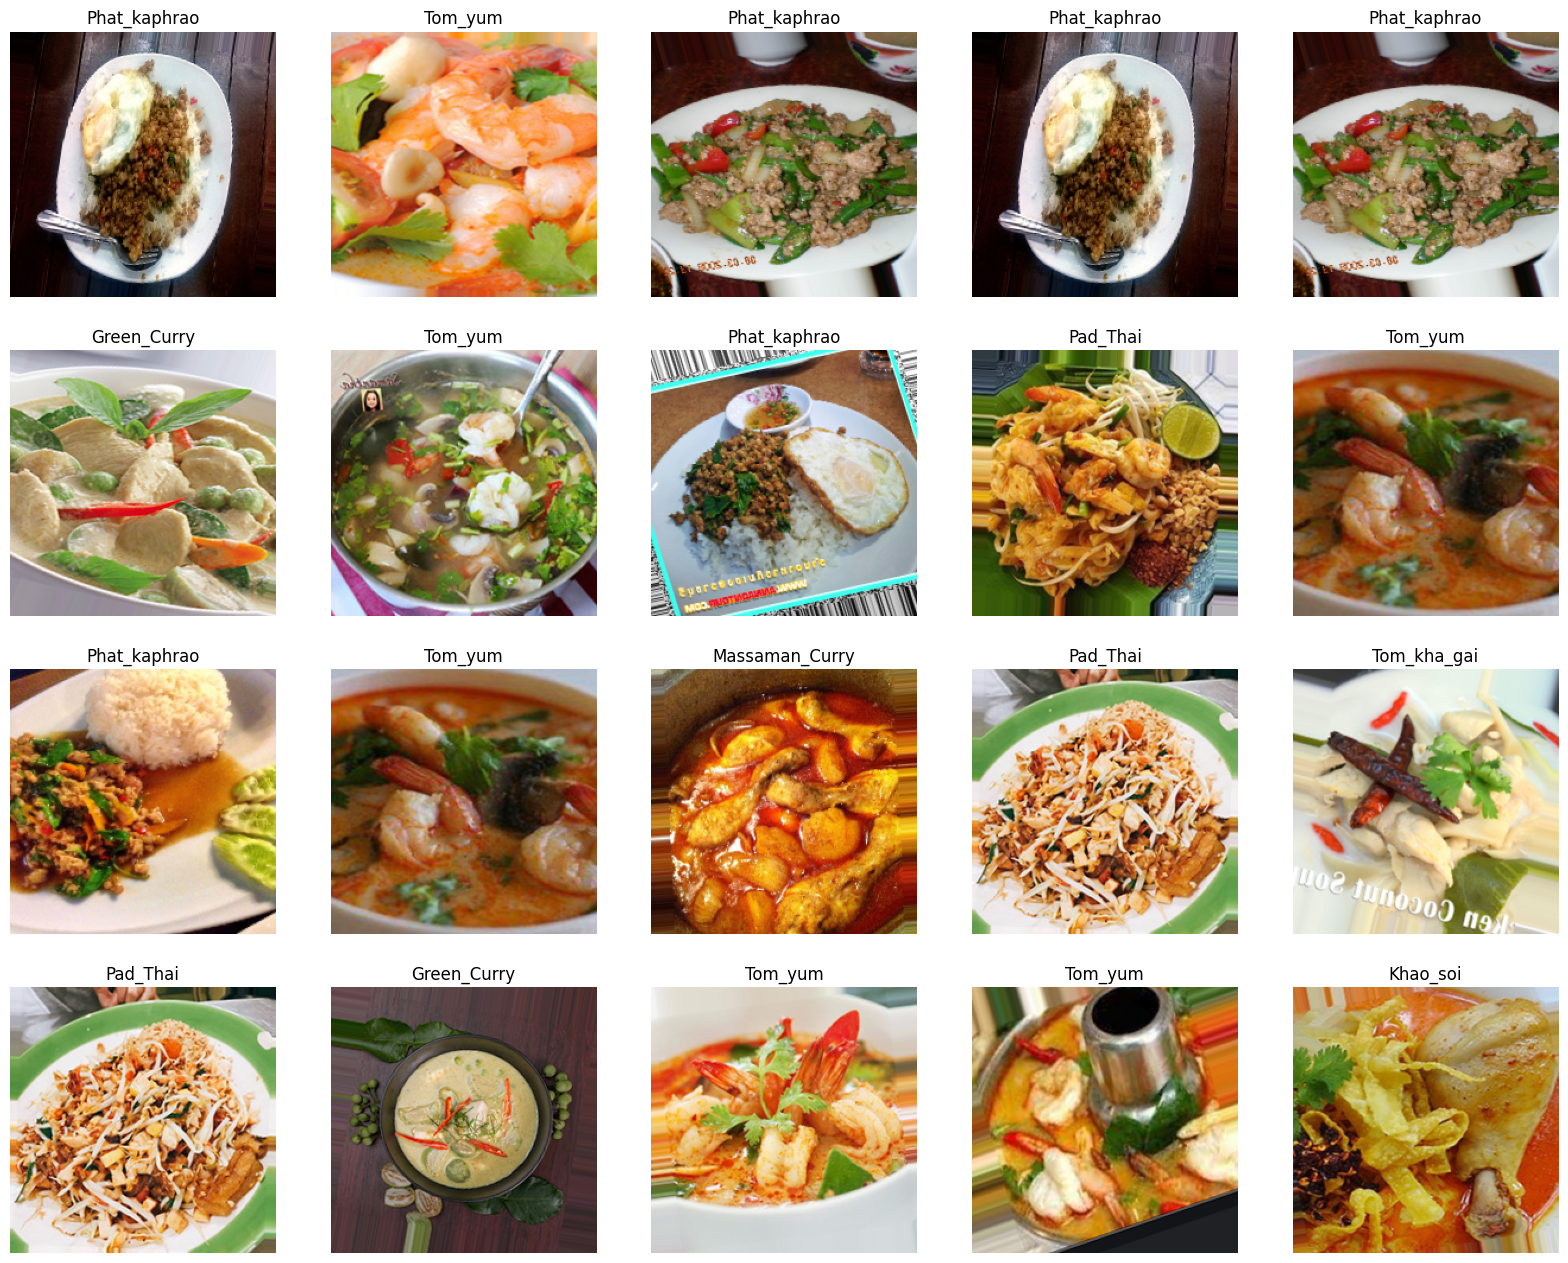

In [11]:
Show_Images(train_generator)

### Testing Data

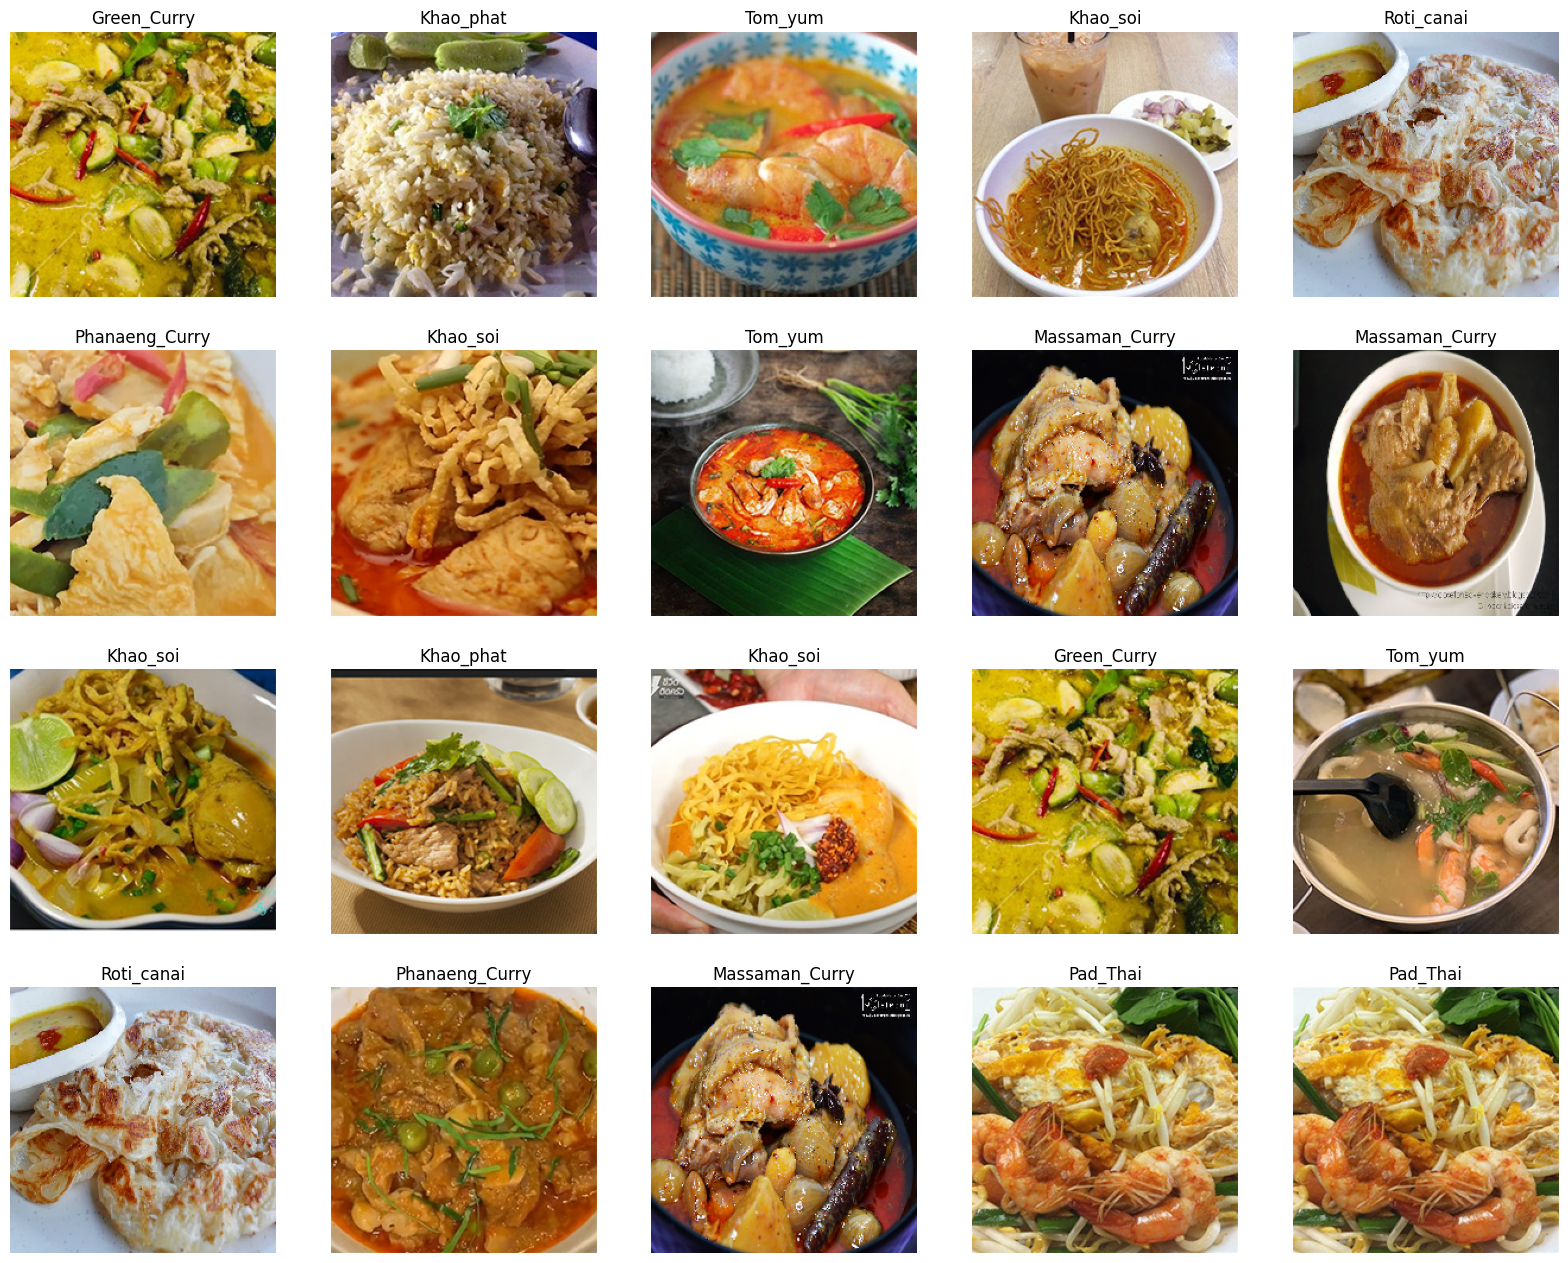

In [12]:
Show_Images(test_generator)

# EarlyStopping

In [13]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Reduction learning_rate

In [14]:
# Configure the learning rate reduction callback
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=10,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

# Exponential Decay

In [15]:
from tensorflow.keras import optimizers

# Create a learning rate schedule using Exponential Decay
learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Initial learning rate for training
    decay_steps=1000,            # Number of steps before decaying the learning rate
    decay_rate=0.5,              # Rate at which the learning rate decreases
)


### Define Callbacks:

#  Compare between Models

In [16]:
# Collect all TL models
TL_Models =[
    ResNet50V2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    ResNet152V2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    InceptionV3(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    Xception(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    MobileNetV2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    VGG19(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False)
]

# Define all the TL models names. This will be later used during visualization
TL_Models_NAMES = [
    'ResNet50V2',
    'ResNet152V2',
    'InceptionV3',
    'Xception',
    'MobileNetV2',
    'VGG19'
]


# Freeze the weights of all the TL models
for tl_model in TL_Models:
    tl_model.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


### Subset from training data

In [ ]:
# Create variables to collect images and labels
subset_images = []
subset_labels = []

# Set the desired number of images you want in the subset
desired_count = 1000

# Loop through the generator until you have collected the desired number of images
for i in range(desired_count):
    # Generate a batch of data (images and labels)
    batch = train_generator.next()
    images, labels = batch
    subset_images.extend(images)
    subset_labels.extend(labels)
    print(labels)

    # Check if you've collected enough images
    if len(subset_images) >= desired_count:
        break

# Convert the collected images and labels to numpy arrays
X_sub = np.array(subset_images)
y_sub = np.array(subset_labels)

In [64]:

def class_weights_prepare(labels):
    cc=0
    result_list=[]
    _n,_d = labels.shape
    for ss in labels:
        re=0
        
        for d in range(_d):
            re += ss[d] * (d+1)

        result_list.append(re)
        cc +=1
    return(result_list)

y_train_list = class_weights_prepare(y_sub)

from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(y_train_list), class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train_list),
                                                 y=y_train_list))) 
class_weights

1024


{1.0: 0.9309090909090909,
 2.0: 0.8904347826086957,
 3.0: 0.9142857142857143,
 4.0: 0.8982456140350877,
 5.0: 0.9660377358490566,
 6.0: 0.8982456140350877,
 7.0: 1.528358208955224,
 8.0: 1.2962025316455696,
 9.0: 0.9752380952380952,
 10.0: 1.003921568627451}

In [74]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()
    
balanced_gen = BalancedDataGenerator(X_sub, y_sub, train_datagen, batch_size=64)
#balanced_gen_val = BalancedDataGenerator(X_val, y_val, valid_datagen, batch_size=64)
steps_per_epoch = balanced_gen.steps_per_epoch

### Training the Models and get Histories

In [75]:
# Initialize an empty list to hold the histories of each TL_models architecture.
HISTORIES = []

# Loop over every backbone in the BACKBONES list.
for tl_model in tqdm(TL_Models, desc="Training Tl Models"):
    
    # Create the simplest model architecture using the current backbone.
    model = keras.Sequential([
        tl_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    
    # Compile the model with the specified loss function, optimizer, and metrics.
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate = learning_rate_schedule),
        metrics='accuracy'
    )
    
    # Train the model on a subset of the training data.
    '''
    history = model.fit(
        X_sub, y_list,
        epochs=20,
        class_weight=class_weights
        validation_split=0.2,
        batch_size=batch_size
    )'''
    
    history = model.fit(balanced_gen, steps_per_epoch, class_weight=class_weights,epochs=30,shuffle=True)
        
    # Store the history of the trained model.
    HISTORIES.append(history.history)

Training Tl Models:   0%|          | 0/6 [00:00<?, ?it/s]


ValueError: `y` argument is not supported when using `keras.utils.Sequence` as input.

### Analyze the performance of TL Models


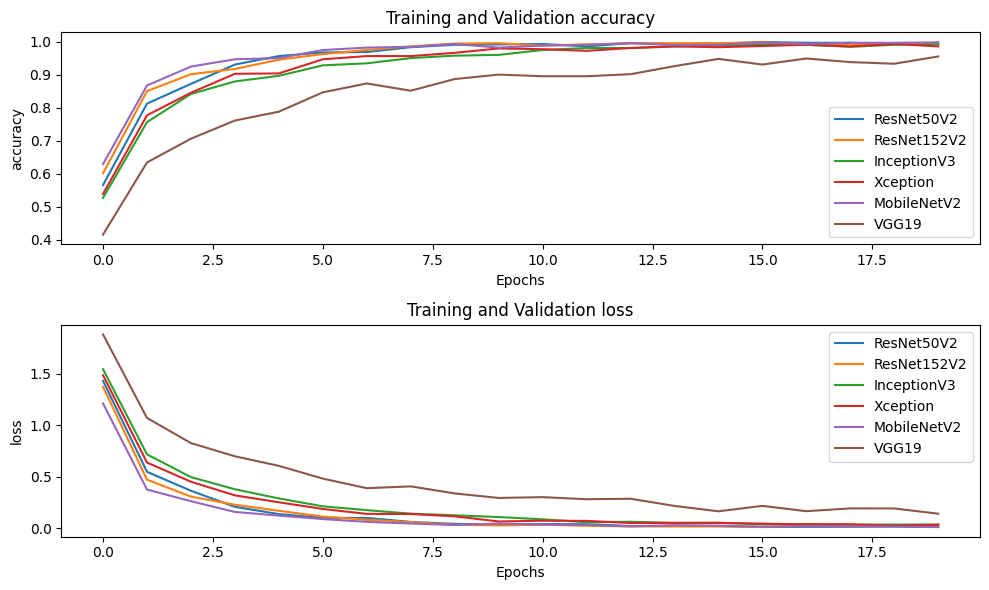

In [25]:
import matplotlib.pyplot as plt

# Define the metrics to plot (e.g., 'accuracy' and 'loss')
metrics_to_plot = ['accuracy', 'loss']

# Create subplots for each metric
fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 6))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 1, i+1)  # Create subplots for each metric
    for idx, history in enumerate(HISTORIES):
        plt.plot(history[metric], label=TL_Models_NAMES[idx])
    plt.title(f'Training and Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

# Choose Model - MobileNetV2

### Get the weights

In [26]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(images_size, images_size, 3))

### Freeze the layers

In [29]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Build the model

In [30]:
model = tf.keras.models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    #layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10,activation='softmax'),
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 256)               327936    
                                                                 
 batch_normalization_104 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                      

### Set the optimizer

In [31]:
from tensorflow.keras import optimizers

optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)

In [32]:
model.compile(optimizer=optimizer,
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

### Training the model

In [35]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=valid_generator,
    batch_size=batch_size,
    validation_steps=valid_generator.samples // batch_size,
    #callbacks=[callback]
)

Epoch 1/100
30/30 [==============================] - 34s 963ms/step - loss: 0.9046 - accuracy: 0.7172 - val_loss: 1.5040 - val_accuracy: 0.7090
Epoch 2/100
30/30 [==============================] - 29s 952ms/step - loss: 0.4836 - accuracy: 0.8364 - val_loss: 0.6770 - val_accuracy: 0.8359
Epoch 3/100
30/30 [==============================] - 28s 933ms/step - loss: 0.3302 - accuracy: 0.8907 - val_loss: 0.4254 - val_accuracy: 0.8555
Epoch 4/100
30/30 [==============================] - 29s 952ms/step - loss: 0.2779 - accuracy: 0.9002 - val_loss: 0.3427 - val_accuracy: 0.8887
Epoch 5/100
30/30 [==============================] - 28s 930ms/step - loss: 0.2517 - accuracy: 0.9090 - val_loss: 0.3990 - val_accuracy: 0.8828
Epoch 6/100
30/30 [==============================] - 28s 922ms/step - loss: 0.2455 - accuracy: 0.9179 - val_loss: 0.3692 - val_accuracy: 0.8887
Epoch 7/100
30/30 [==============================] - 28s 934ms/step - loss: 0.2418 - accuracy: 0.9164 - val_loss: 0.4801 - val_accuracy:

KeyboardInterrupt: 

### Plot Loss

In [29]:
h1 = go.Scatter(y=history.history['loss'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='blue'),
                    name="loss"
                   )
h2 = go.Scatter(y=history.history['val_loss'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='red'),
                    name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='Epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
plotly.offline.iplot(fig1)


### Plot ACC

In [30]:
h1 = go.Scatter(y=history.history['accuracy'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=history.history['val_accuracy'], 
                    mode="lines",
                    line=dict(
                        width=2,
                        color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='Epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
plotly.offline.iplot(fig1)


# Evaluate the model

### Evaluate the testing

In [31]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.35083311796188354
Test accuracy: 0.9052631855010986


1/1 [==============================] - 1s 790ms/step


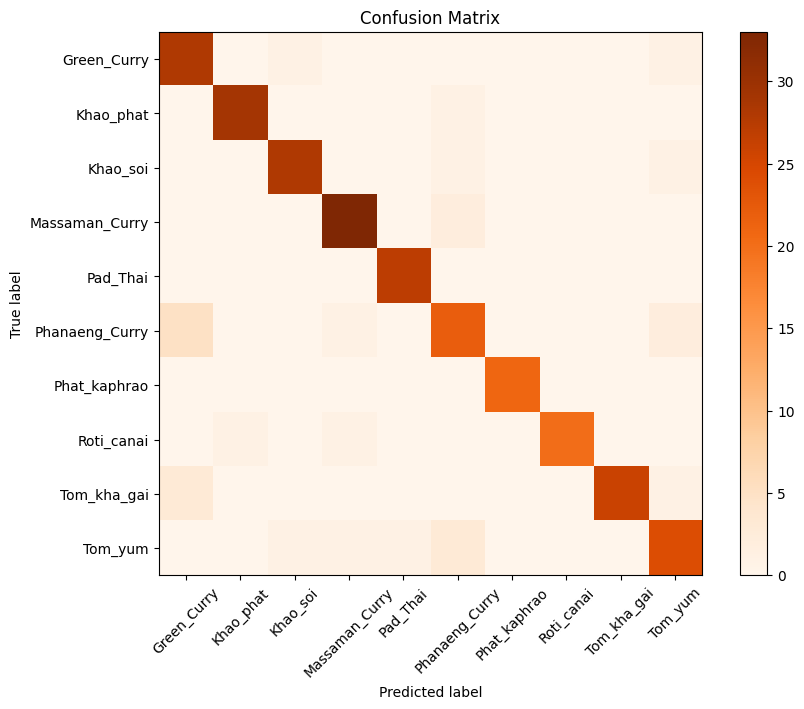

In [33]:
true_labels = []
predicted_labels = []

num_batches = len(test_generator)
for i in range(num_batches):
    x_batch, y_batch = test_generator[i]
    predictions = model.predict(x_batch)
    true_labels.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(predictions, axis=1))


class_names = test_generator.class_indices.keys()    
# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(9, 7))
# Create a visualization of the confusion matrix
classes = [str(i) for i in range(len(test_generator.class_indices))]
plt.imshow(confusion, interpolation='nearest', cmap=plt.get_cmap('Oranges'))
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [34]:
# Calculate the classification report
report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices)

# Print the classification report
print(report)

                precision    recall  f1-score   support

   Green_Curry       0.78      0.93      0.85        30
     Khao_phat       0.97      0.97      0.97        30
      Khao_soi       0.93      0.93      0.93        30
Massaman_Curry       0.92      0.94      0.93        35
      Pad_Thai       0.96      1.00      0.98        27
Phanaeng_Curry       0.76      0.73      0.75        30
  Phat_kaphrao       1.00      1.00      1.00        21
    Roti_canai       1.00      0.91      0.95        22
   Tom_kha_gai       1.00      0.87      0.93        30
       Tom_yum       0.83      0.80      0.81        30

      accuracy                           0.91       285
     macro avg       0.91      0.91      0.91       285
  weighted avg       0.91      0.91      0.91       285



# Generate predictions for the test data

2/2 [==============================] - 0s 46ms/step


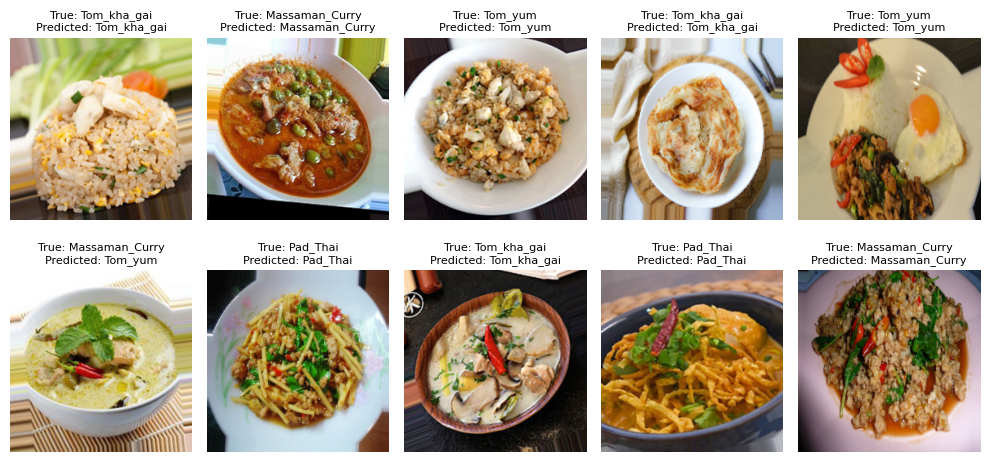

In [35]:
# Collect true labels and model predictions
true_labels = []
predicted_labels = []
class_names = test_generator.class_indices.keys()    
class_names = list(class_names)
num_batches = len(train_generator)
for i in range(10):
    x_batch, y_batch = train_generator[i]
    predictions = model.predict(x_batch)
    true_labels.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(predictions, axis=1))


true_class_labels = [class_names[i] for i in true_labels]
predicted_class_labels = [class_names[i] for i in predicted_labels]

# Plot true labels and predicted labels
plt.figure(figsize=(10, 5))
num_samples_to_display = min(10, len(x_batch))  # Display up to 10 samples or less if available
for i in range(num_samples_to_display):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f'True: {true_class_labels[i]}\nPredicted: {predicted_class_labels[i]}', fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()